# SIT742: Modern Data Science 
**(Assessment Task 02: Bank Marketing Data Analytics)**

---
- Materials in this module include resources collected from various open-source online repositories.
- You are free to use, change and distribute this package.

Prepared by **SIT742 Teaching Team**


---

**Project Group Information:**

- Names: Anand Bhat and Pooja Bhat
- Student IDs: 218546973, 218545396
- Emails: ahbhat@deakin.edu.au, pabhat@deakin.edu.au

---

# 1.Import Spark

In [98]:
!pip install wget
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz -O spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-2.4.0-bin-hadoop2.7'

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession 

# 2.Read and check data

In [0]:
import wget
import shutil

# Get bank.csv data
target = 'bank.csv'
source = 'https://github.com/tulip-lab/sit742/raw/master/Assessment/2019/data/bank.csv'
downloaded_file = wget.download(source, target)
# Overwrite file if already exists
if os.path.exists(target):
    shutil.move(downloaded_file, target)

In [101]:
!ls


bank.csv		    purchase_fre_poutcome.png
purchase_fre_default.png    sample_data
purchase_fre_education.png  skulls.csv
purchase_fre_housing.png    spark-2.4.0-bin-hadoop2.7
purchase_fre_job.png	    spark-2.4.0-bin-hadoop2.7.tgz
purchase_fre_loan.png	    spark-warehouse
purchase_fre_marital.png


In [102]:
spark = SparkSession.builder.appName('ml-bank').getOrCreate()

# Import 'bank.csv' as a Spark dataframe
df = spark.read.csv(path='bank.csv', header=True, inferSchema=True)
df.show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  

In [103]:
# check data distribution
df.printSchema()

# Check each column to analyze if the data is categorical or metric
df.describe().show()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)

+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|summary|               age|    job| marital|education|default|           balance|housing| loan| contact|        

**Summary of analysis:**

From the anaysis of the data, we can see that there are a total of 11162 records in the data frame.

*Numerical Fields*: Age, balance, day, duration, campaign, pdays and previous are numeric fields.

*Categorical Fields*: Job, marital, education, default, housing, loan, contact, month, poutcome and deposit are categorical fields.

# 3.Select features

In [0]:
# Select features age, job, marital, education, default, balance, housing,
# loan, campaign, pdays, previous, poutcome and deposit
df2 = df.select('age', 'job', 'marital', 'education', 'default', 'balance',
                'housing', 'loan', 'campaign', 'pdays', 'previous', 'poutcome',
                'deposit')

In [105]:
# remove invalid rows/records using spark.sql
# Register the DataFrame as a temporary table
df2.registerTempTable('bank')

# Include records where poutcome has either success or failure as valid values
# and none of the other fields contain the value 'unknown'
valid_bank_data = spark.sql("SELECT * FROM bank WHERE education != 'unknown'" +
                            " AND marital != 'unknown'" +
                            " AND job != 'unknown'" +
                            " AND default != 'unknown'" +
                            " AND housing != 'unknown'" +
                            " AND deposit != 'unknown'" +
                            " AND loan != 'unknown'" +
                            " AND poutcome IN ('failure', 'success')")
valid_bank_data.describe().show()

+-------+------------------+----------+--------+---------+-------+------------------+-------+----+------------------+-----------------+------------------+--------+-------+
|summary|               age|       job| marital|education|default|           balance|housing|loan|          campaign|            pdays|          previous|poutcome|deposit|
+-------+------------------+----------+--------+---------+-------+------------------+-------+----+------------------+-----------------+------------------+--------+-------+
|  count|              2181|      2181|    2181|     2181|   2181|              2181|   2181|2181|              2181|             2181|              2181|    2181|   2181|
|   mean| 41.84364970197157|      null|    null|     null|   null| 1742.946813388354|   null|null|1.8211829436038514|202.8578633654287|3.0917010545621273|    null|   null|
| stddev|12.855329179952637|      null|    null|     null|   null|3397.7939950723485|   null|null|1.2274126864078023|121.3097255486155| 2.95

After Elimination of columns with invalid values we have a total of 2181 records. We will then try to explore the data and see how they influence the deposit column

Next, we will convert the categorical columns into numberic columns using one hot encoding. 
After that, all columns will be normalized between values 0 and 1 using MinMaxScaler
These will later be converted to features so they could be used for supervised and unsupervised machine learning techniques.

**Data Exploration**

--------------------------------------------------------------------------------------------------------------
Percentage of deposits v/s no deposits
--------------------------------------------------------------------------------------------------------------
The percentage of no subsciption of deposit is 31.040806969280148 %
The percentage of subsciption of deposit is 68.95919303071986 %
--------------------------------------------------------------------------------------------------------------
We will group by the deposit and see how the numeric features show any insights to a positive deposit outcome
--------------------------------------------------------------------------------------------------------------
               age      balance  campaign       pdays  previous
deposit                                                        
no       40.611521  1347.843427  2.028065  232.381093  3.001477
yes      42.398271  1920.795878  1.728059  189.568484  3.132314
-------------------

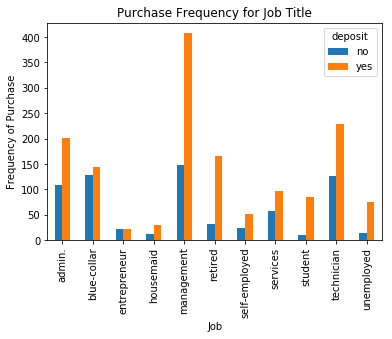

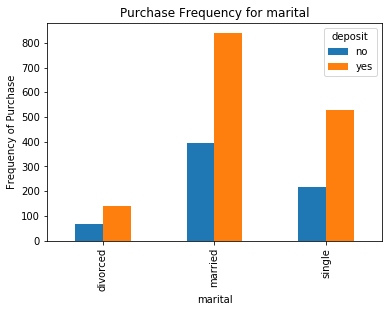

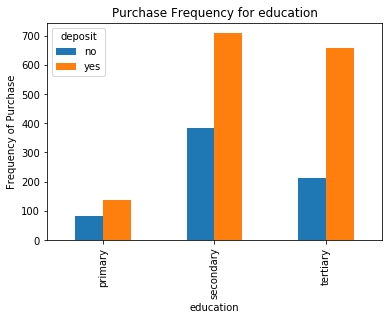

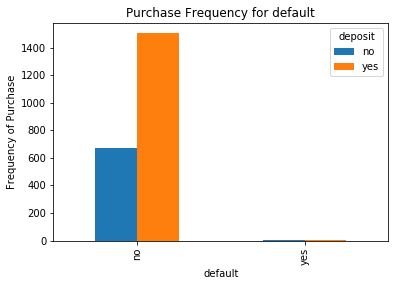

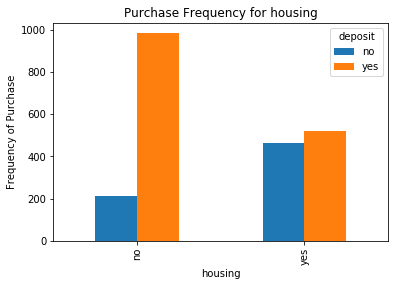

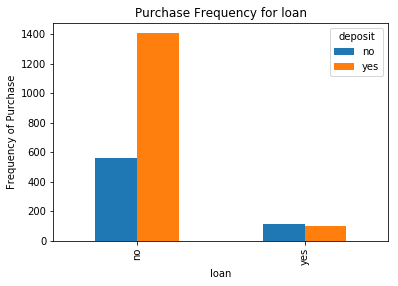

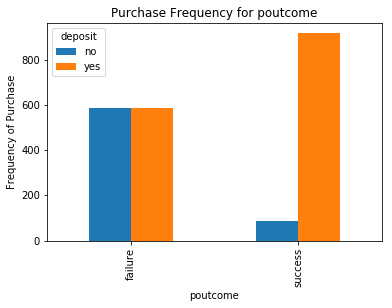

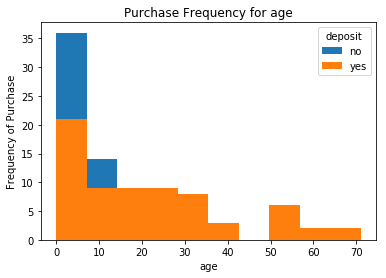

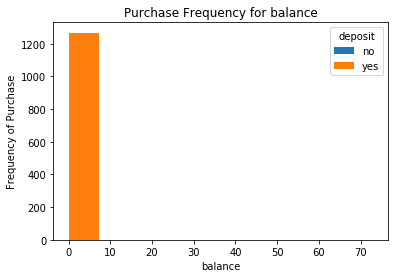

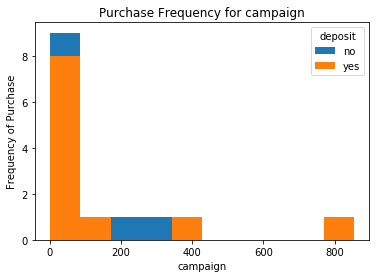

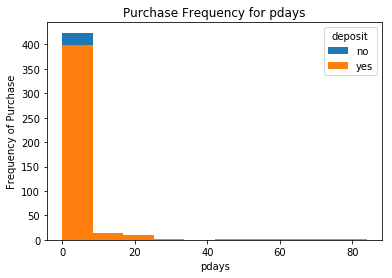

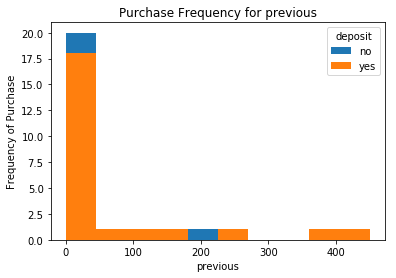

In [122]:
# We will try to explore the different variables to see if we can see any of the variables influencing the deposits 
# Deposits are either yes or no 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

valid_bank_data_explore = valid_bank_data.toPandas()
valid_bank_data_explore['deposit'].value_counts()

# Calculate the percentage of deposits v/s no deposits
print("--------------------------------------------------------------------------------------------------------------")
print("Percentage of deposits v/s no deposits")
print("--------------------------------------------------------------------------------------------------------------")
count_sub = len(valid_bank_data_explore[valid_bank_data_explore['deposit']=='yes'])
count_no_sub = len(valid_bank_data_explore[valid_bank_data_explore['deposit']=='no'])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("The percentage of no subsciption of deposit is", pct_of_no_sub*100,"%")
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("The percentage of subsciption of deposit is", pct_of_sub*100,"%")

print("--------------------------------------------------------------------------------------------------------------")
print("We will group by the deposit and see how the numeric features show any insights to a positive deposit outcome")
print("--------------------------------------------------------------------------------------------------------------")
print(valid_bank_data_explore.groupby('deposit').mean())

# Purchase Frequency by Job Title
print("--------------------------------------------------------------------------------------------------------------")
pd.crosstab(valid_bank_data_explore.job,valid_bank_data_explore.deposit).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

# Purchase Frequency by marital status
pd.crosstab(valid_bank_data_explore.marital,valid_bank_data_explore.deposit).plot(kind='bar')
plt.title('Purchase Frequency for marital')
plt.xlabel('marital')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_marital')

# Purchase Frequency for education
pd.crosstab(valid_bank_data_explore.education,valid_bank_data_explore.deposit).plot(kind='bar')
plt.title('Purchase Frequency for education')
plt.xlabel('education')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_education')

# Purchase Frequency for default
pd.crosstab(valid_bank_data_explore.default,valid_bank_data_explore.deposit).plot(kind='bar')
plt.title('Purchase Frequency for default')
plt.xlabel('default')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_default')

# Purchase Frequency for housing
pd.crosstab(valid_bank_data_explore.housing,valid_bank_data_explore.deposit).plot(kind='bar')
plt.title('Purchase Frequency for housing')
plt.xlabel('housing')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_housing')

# Purchase Frequency for loan
pd.crosstab(valid_bank_data_explore.loan,valid_bank_data_explore.deposit).plot(kind='bar')
plt.title('Purchase Frequency for loan')
plt.xlabel('loan')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_loan')

# Purchase Frequency for poutcome
pd.crosstab(valid_bank_data_explore.poutcome,valid_bank_data_explore.deposit).plot(kind='bar')
plt.title('Purchase Frequency for poutcome')
plt.xlabel('poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_poutcome')

# Purchase Frequency for age
pd.crosstab(valid_bank_data_explore.age,valid_bank_data_explore.deposit).plot(kind='hist')
plt.title('Purchase Frequency for age')
plt.xlabel('age')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_age')

# Purchase Frequency for balance
pd.crosstab(valid_bank_data_explore.balance,valid_bank_data_explore.deposit).plot(kind='hist')
plt.title('Purchase Frequency for balance')
plt.xlabel('balance')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_balance')

# Purchase Frequency for campaign
pd.crosstab(valid_bank_data_explore.campaign,valid_bank_data_explore.deposit).plot(kind='hist')
plt.title('Purchase Frequency for campaign')
plt.xlabel('campaign')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_campaign')

# Purchase Frequency for pdays
pd.crosstab(valid_bank_data_explore.pdays,valid_bank_data_explore.deposit).plot(kind='hist')
plt.title('Purchase Frequency for pdays')
plt.xlabel('pdays')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_pdays')

# Purchase Frequency for previous
pd.crosstab(valid_bank_data_explore.previous,valid_bank_data_explore.deposit).plot(kind='hist')
plt.title('Purchase Frequency for previous')
plt.xlabel('previous')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_previous')



**Some Observations**

 - The average age of the customers who have deposits is higher as compared to the avergare age of customers who have not subscribed for deposit.

- The average balance of the customers with deposits was higher compared to the customers who did not have deposits

- The average campaign ( avergage number of contacts performed) were actually surprisingly lower in case of customers who had deposits compared to customers who did not have deposits

- The average pdays (number of days that passed by after a previous campaign) were lower in case of customers who had deposits compared to customers who did not have deposits

- The average number of contacts performed before this campaign (previous) were slightly higher in case of customers who had deposits compared to customers who did not have deposit.

- The barplots between the features and deposit field shows some significan evidence that features such as age, education and job have some influence on deposit

In [107]:
#Covert categorical features to metric features using One hot encoding
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

df2 = valid_bank_data.select("age","job","marital","education","default","balance","housing","loan","campaign","pdays","previous","poutcome","deposit")
cols = df2.columns

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol,
                                  outputCol=categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()],
                                     outputCols=[categoricalCol + 'classVec'])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol='deposit', outputCol='label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs,
                            outputCol="features_for_scaling")
stages += [assembler]

pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(dataset=df2)
df2 = pipelineModel.transform(dataset=df2)
selectedCols = ['label', 'features_for_scaling'] + cols
df2 = df2.select(selectedCols)
#df2.printSchema()

print('Dataframe after OHE and adding features and label before scaling')
df2.show(truncate=False)


Dataframe after OHE and adding features and label before scaling
+-----+-------------------------------------------------------------------------------------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|label|features_for_scaling                                                                             |age|job         |marital |education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+-----+-------------------------------------------------------------------------------------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|0.0  |(23,[5,10,12,14,16,17,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,1.0,33.0,3444.0,1.0,91.0,4.0])        |33 |services    |married |secondary|no     |3444   |yes    |no  |1       |91   |4       |failure |yes    |
|0.0  |(23,[1,10,12,14,16,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,56.0,589.0,1.0,147.0,2.0

## 3.1 normalisation

In [108]:
#Apply Min-Max normalisation on each attribute using MinMaxScaler  
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors

df3=df2
scaler_features = MinMaxScaler(inputCol="features_for_scaling",
                               outputCol="features")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel_features = scaler_features.fit(dataset=df3)

# rescale each feature to range [min, max].
df3 = scalerModel_features.transform(dataset=df3)
print('Features scaled to range: [%f, %f]\n' % (scaler_features.getMin(),
                                              scaler_features.getMax()))

print('Dataframe with columns of interest (features and label) after scaling')
df3.select('features_for_scaling', 'features', 'deposit', 'label').show(truncate=False)

Features scaled to range: [0.000000, 1.000000]

Dataframe with columns of interest (features and label) after scaling
+-------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+-----+
|features_for_scaling                                                                             |features                                                                                                                                                                       |deposit|label|
+-------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+-----+
|(23,[5,10,1

# 4.Unsupervised learning

## 4.1 K-means

Run K-means algorithm on the derived features to predict the clusters
+--------------------+----------+-------+-----+
|            features|prediction|deposit|label|
+--------------------+----------+-------+-----+
|[0.0,0.0,0.0,0.0,...|         1|    yes|    0|
|[0.0,1.0,0.0,0.0,...|         1|    yes|    0|
|[0.0,0.0,1.0,0.0,...|         0|    yes|    0|
|[0.0,0.0,0.0,0.0,...|         0|    yes|    0|
|[0.0,1.0,0.0,0.0,...|         1|    yes|    0|
|[0.0,0.0,0.0,0.0,...|         1|    yes|    0|
|[0.0,0.0,0.0,0.0,...|         1|    yes|    0|
|[1.0,0.0,0.0,0.0,...|         0|    yes|    0|
|[0.0,1.0,0.0,0.0,...|         0|    yes|    0|
|[0.0,0.0,0.0,1.0,...|         1|    yes|    0|
|[0.0,1.0,0.0,0.0,...|         0|    yes|    0|
|[0.0,0.0,0.0,0.0,...|         0|    yes|    0|
|[0.0,0.0,0.0,0.0,...|         1|    yes|    0|
|[0.0,0.0,0.0,0.0,...|         1|    yes|    0|
|[0.0,0.0,0.0,1.0,...|         1|    yes|    0|
|[0.0,1.0,0.0,0.0,...|         1|    yes|    0|
|[1.0,0.0,0.0,0.0,

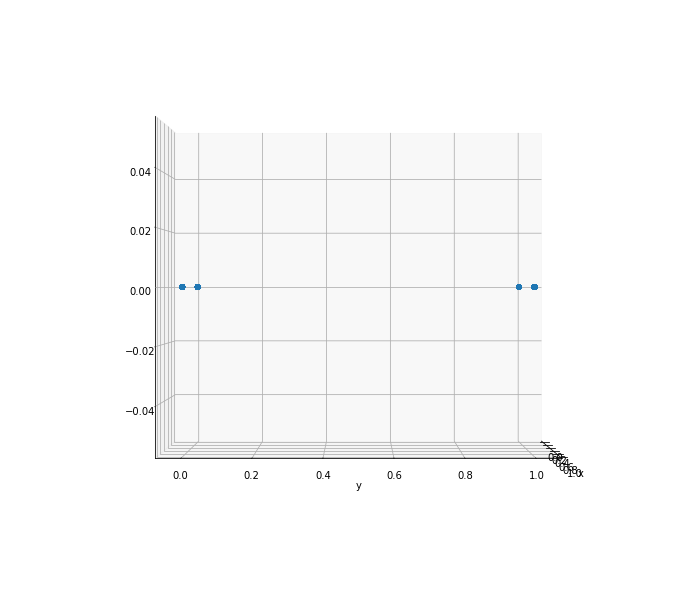

In [109]:
# Perform unsupervised learning on df2 with k-means 
 
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

print('Run K-means algorithm on the derived features to predict the clusters')
kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(dataset=df3.select('features'))

transformed = model.transform(dataset=df3).selectExpr(
    'features', 'prediction', 'deposit', 'cast(label as int) label')
transformed.show()

# Evaluate the clustering result using Accuracy. 
# Since k-means is meant to cluster, rather than to compare clusters to known groups, this might not be the best way to evaluate the accuracy of model performance
# For the purpose of analysis in this case, we will try to compare the predictions from k-means with the actual known deposit values.
print('Compare the percentages of predictions that are matching the deposits')
transformed.registerTempTable('Accuracy')

# Find the percentage of prediations that match the deposit label
print('Predictions that match the deposit label')
Correct_predictions = spark.sql("select sum(count) count_matching, 2181 as total_count, sum(count)*100/2181 percentage_predicted_correctly from (SELECT label, prediction, count(*) as count FROM Accuracy WHERE group by label, prediction) a where label=prediction")
Correct_predictions.show()

# Find the percentage of prediations that do not match the deposit label
print("--------------------------------------------------------------------------------------------------------------")
print("Prediction that do not match the deposit label")
print("--------------------------------------------------------------------------------------------------------------")
InCorrect_predictions = spark.sql("select sum(count) count_not_matching,2181 as total_count,sum(count)*100/2181 percentage_predicted_incorrectly from (SELECT label, prediction, count(*) as count FROM Accuracy WHERE group by label, prediction) a where label!=prediction")
InCorrect_predictions.show()

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(transformed)
print("--------------------------------------------------------------------------------------------------------------")
print("Silhouette with squared euclidean distance = " + str(silhouette))
print("--------------------------------------------------------------------------------------------------------------")

# Shows the result.
centers = model.clusterCenters()
print("--------------------------------------------------------------------------------------------------------------")
print("Cluster Centers: ")
print("--------------------------------------------------------------------------------------------------------------")
for center in centers:
    print(center)

# Map the predicted values with deposit labels to see how the scatter is
pddf_pred = transformed.toPandas()
pddf_pred.head()

print("--------------------------------------------------------------------------------------------------------------")
print("Scatter diagram of predictions v/s deposits")
print("--------------------------------------------------------------------------------------------------------------")
fig = plt.figure(1, figsize=(10, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=0, azim=0)
ax.scatter(pddf_pred.label,pddf_pred.prediction) 
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()




## 4.2 PCA

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------+
|features                                                                                                                                                                       |pcaFeatures                              |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------+
|[0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.21428571428571427,0.05334664361715079,0.0,0.10550996483001172,0.05555555555555555]                  |[0.9636424850516068,0.3313811478935345]  |
|[0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.5428571428571428,0.018589759197487277,0.0,0.

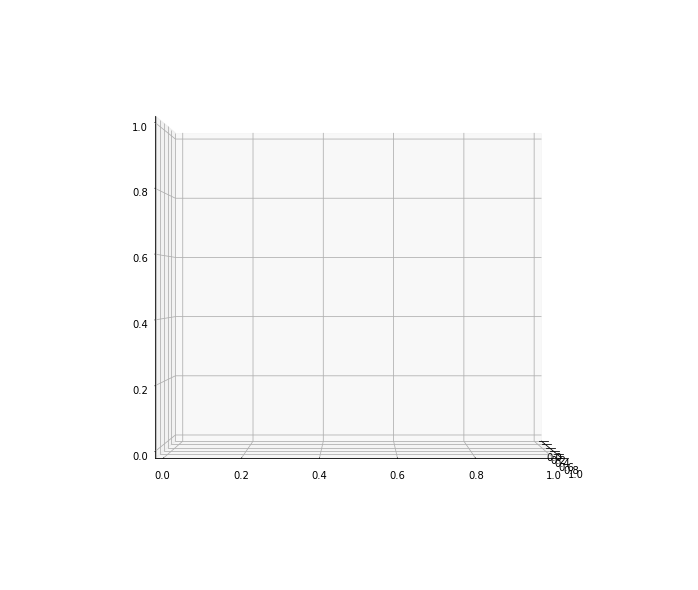

In [110]:
#Generate a scatter plot using the first two PCA components to investigate the data distribution.
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(transformed)

result = model.transform(transformed).select("features","pcaFeatures")
result.show(truncate=False)

features = result.select('pcaFeatures').rdd.map(lambda x: np.array(x))

fig = plt.figure(1, figsize=(10, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=0, azim=0)
#ax.scatter(features[:, 0], features[:, 1],features[:, 2], c=y, cmap=plt.cm.Spectral)

# 5.Supervised learning

In [111]:
df2=df3
train, test = df2.randomSplit([0.7, 0.3], seed = 742)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 1535
Test Dataset Count: 646


## 5.1 LogisticRegression

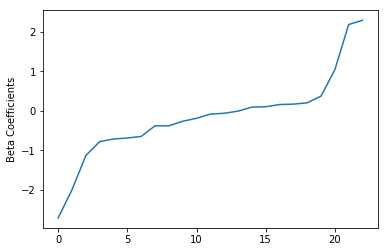

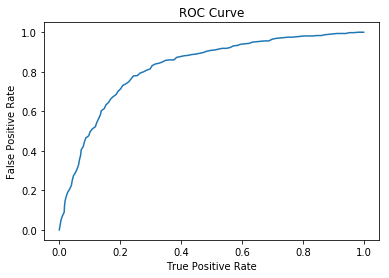

Training set areaUnderROC: 0.8235413898905551


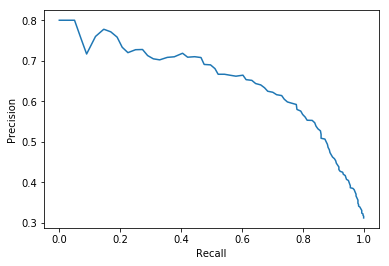

+---+---------+----------+-----+--------------------+----------+--------------------+
|age|education|       job|label|       rawPrediction|prediction|         probability|
+---+---------+----------+-----+--------------------+----------+--------------------+
| 29|secondary|management|  0.0|[0.20581400401594...|       0.0|[0.55127263878287...|
| 52|secondary|management|  0.0|[0.31464400007368...|       0.0|[0.57801840224098...|
| 48|secondary|management|  0.0|[2.75843511433406...|       0.0|[0.94038796941248...|
| 33|secondary|management|  0.0|[-0.0148119354374...|       1.0|[0.49629708384002...|
| 48|secondary|management|  0.0|[-0.4210045818029...|       1.0|[0.39627638754076...|
| 49|secondary|management|  0.0|[-0.4097384848671...|       1.0|[0.39897482923205...|
| 31| tertiary|management|  0.0|[0.97185596686588...|       0.0|[0.72548927674934...|
| 32| tertiary|management|  0.0|[0.99783494329516...|       0.0|[0.73063268975904...|
| 33| tertiary|management|  0.0|[0.66785620582997...| 

In [133]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
import matplotlib.pyplot as plt
import numpy as np

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

# Obtain the coefficients by using LogisticRegressionModel’s attributes.
beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

#Summarize the model over the training set, we can also obtain the receiver-operating characteristic and areaUnderROC.
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

# Make predictions on the test set.
predictions = lrModel.transform(test)
predictions.select('age', 'education', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

# Evaluate our Logistic Regression model.
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

In [135]:
#Exam the coefficients


# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

objectiveHistory:
0.620732771145114
0.5367862886008634
0.5072721508745247
0.49804635199987257
0.4953367707078175
0.4897081478139117
0.4741263260040615
0.4715911493198809
0.46972653008103016
0.4694081656644506
0.46927930786556016
+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|0.002840909090909091|0.025052192066805846|
|0.005681818181818182| 0.05010438413361169|
|0.010416666666666666|  0.0709812108559499|
|0.016098484848484848| 0.08977035490605428|
|0.017045454545454544| 0.11899791231732777|
| 0.01893939393939394| 0.14613778705636743|
|0.022727272727272728| 0.16910229645093947|
|0.027462121212121212| 0.18997912317327767|
| 0.03409090909090909| 0.20668058455114824|
| 0.03977272727272727|  0.2254697286012526|
| 0.04261363636363636| 0.25052192066805845|
| 0.04640151515151515| 0.27348643006263046|
| 0.05303030303030303| 0.29018789144050106|
|0.058712121212121215| 

## 5.2 Decision tree

In [114]:
#Decision tree
from pyspark.ml.classification import DecisionTreeClassifier 

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

+---+----------+-----+-------------+----------+--------------------+
|age|       job|label|rawPrediction|prediction|         probability|
+---+----------+-----+-------------+----------+--------------------+
| 29|management|  0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 52|management|  0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 48|management|  0.0| [631.0,54.0]|       0.0|[0.92116788321167...|
| 33|management|  0.0|[177.0,300.0]|       1.0|[0.37106918238993...|
| 48|management|  0.0|[177.0,300.0]|       1.0|[0.37106918238993...|
| 49|management|  0.0|[177.0,300.0]|       1.0|[0.37106918238993...|
| 31|management|  0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 32|management|  0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 33|management|  0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 34|management|  0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
+---+----------+-----+-------------+----------+--------------------+
only showing top 10 rows

Test Are

## 5.3 NaiveBayes

In [115]:
#NaiveBayes
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

nb = NaiveBayes(smoothing=1)
model = nb.fit(train)

predictions = model.transform(test)
predictions.filter(predictions['prediction'] == 0) \
    .select("age","job","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

+---+----------+------------------------------+-----+----------+
|age|       job|                   probability|label|prediction|
+---+----------+------------------------------+-----+----------+
| 30|unemployed|[0.9732419352200333,0.02675...|  1.0|       0.0|
| 34|unemployed|[0.9718353353707406,0.02816...|  0.0|       0.0|
| 41|unemployed|[0.9716223100472741,0.02837...|  0.0|       0.0|
| 26|   student|[0.9697424424351907,0.03025...|  0.0|       0.0|
| 26|   student|[0.9686721289812447,0.03132...|  1.0|       0.0|
| 31|unemployed|[0.9643304662857318,0.03566...|  0.0|       0.0|
| 68|   retired|[0.9638368901492667,0.03616...|  0.0|       0.0|
| 69|   retired|[0.9632138966479422,0.03678...|  0.0|       0.0|
| 59|   retired|[0.9548934327512716,0.04510...|  0.0|       0.0|
| 76|   retired|[0.9535349431003585,0.04646...|  1.0|       0.0|
+---+----------+------------------------------+-----+----------+
only showing top 10 rows



0.7150891013081523